In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# window에 있는 글꼴로 한글 폰트 설정하기
import matplotlib
import matplotlib.font_manager as fm

font_path = "C:\\Windows\\Fonts\\malgun.TTF"
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
matplotlib.rc('font', family=font_name)

#축의 음수값 에러 해결을 위한 설정
plt.rc('axes', unicode_minus=False)

In [3]:
def load_yearly_happiness_data(target_directory):
    """
    지정된 폴더 내의 연도별 세계 행복 지수 CSV 파일들을 읽어 데이터프레임 딕셔너리로 반환합니다.

    Parameters:
        target_directory (str): CSV 파일들이 저장된 디렉토리 경로 (예: "../data")

    Returns:
        dict: 파일명(연도)을 키(key)로 하고, pandas DataFrame을 값(value)으로 가지는 딕셔너리
    """
    file_names = os.listdir(target_directory)  # 지정된 경로의 파일 목록 불러오기
    yearly_df_dict = {}

    for file_name in file_names:
        if file_name.endswith(".csv"):  # 확장자가 .csv인 파일만 필터링
            year_key = file_name.split(".")[0]  # 파일명에서 연도 추출하여 키로 사용
            full_path = os.path.join(target_directory, file_name)  # 안전한 파일 경로 생성

            yearly_df = pd.read_csv(full_path)  # CSV 파일을 DataFrame으로 로드
            yearly_df_dict[year_key] = yearly_df  # 딕셔너리에 저장

    return yearly_df_dict

data_dir_path = "../data"
happiness_data_dict = load_yearly_happiness_data(data_dir_path)

sample_df = happiness_data_dict["2015"]
display(sample_df.head())

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


In [4]:
def standardize_and_merge_data(happiness_data_dict):
    """
    연도별 행복 지수 데이터프레임 딕셔너리를 일관된 컬럼명으로 표준화하고 하나의 데이터프레임으로 병합합니다.

    Parameters:
        happiness_data_dict (dict): 연도(문자열)를 키(key)로, pandas DataFrame을 값(value)으로 가지는 딕셔너리

    Returns:
        pandas.DataFrame: 핵심 컬럼이 표준화되고 'year' 컬럼이 추가된 10년 치 통합 데이터프레임
    """
    column_mapping = {
        "Country": "country",
        "Country or region": "country",
        "Country name": "country",
        "Happiness Rank": "happiness_rank",
        "Happiness.Rank": "happiness_rank",
        "Overall rank": "happiness_rank",
        "Happiness Score": "happiness_score",
        "Happiness.Score": "happiness_score",
        "Score": "happiness_score",
        "Happiness score": "happiness_score",
        "Economy (GDP per Capita)": "gdp_per_capita",
        "Economy..GDP.per.Capita.": "gdp_per_capita",
        "GDP per capita": "gdp_per_capita",
        "Economy (GDP per Capita)\t": "gdp_per_capita",
        "Family": "social_support",
        "Social support": "social_support",
        "Health (Life Expectancy)": "healthy_life_expectancy",
        "Health..Life.Expectancy.": "healthy_life_expectancy",
        "Healthy life expectancy": "healthy_life_expectancy",
        "Freedom": "freedom",
        "Freedom to make life choices": "freedom",
        "Trust (Government Corruption)": "corruption_perception",
        "Trust..Government.Corruption.": "corruption_perception",
        "Perceptions of corruption": "corruption_perception",
        "Generosity": "generosity"
    }  # 연도별로 상이한 원본 컬럼명을 통일하기 위한 매핑 딕셔너리

    standardized_dfs = []  # 표준화된 개별 데이터프레임을 담을 리스트

    for year_key, yearly_df in happiness_data_dict.items():
        yearly_df = yearly_df.rename(columns=column_mapping)  # 매핑 딕셔너리를 적용하여 컬럼명 일괄 변경

        target_columns = [
            "country", "happiness_rank", "happiness_score", "gdp_per_capita",
            "social_support", "healthy_life_expectancy", "freedom",
            "generosity", "corruption_perception"
        ]  # 병합에 사용할 핵심 타겟 컬럼 목록

        available_columns = [col for col in target_columns if col in yearly_df.columns]  # 현재 연도 데이터에 존재하는 타겟 컬럼만 필터링
        filtered_df = yearly_df[available_columns].copy()  # 필터링된 컬럼만 추출하여 독립된 복사본 생성

        filtered_df["year"] = int(year_key)  # 데이터의 연도를 나타내는 새로운 컬럼 추가

        standardized_dfs.append(filtered_df)  # 처리된 데이터프레임을 리스트에 추가

    merged_df = pd.concat(standardized_dfs, ignore_index=True)  # 리스트 안의 모든 데이터프레임을 인덱스를 무시하고 하나로 병합
    return merged_df

merged_happiness_df = standardize_and_merge_data(happiness_data_dict)

display(merged_happiness_df.head())
display(merged_happiness_df.info())

,country,happiness_rank,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom,generosity,corruption_perception,year
0,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,2015
1,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145,2015
2,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,2015
3,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503,2015
4,Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957,2015


<class 'pandas.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   country                  1510 non-null   str    
 1   happiness_rank           1510 non-null   int64  
 2   happiness_score          1510 non-null   float64
 3   gdp_per_capita           1507 non-null   float64
 4   social_support           1507 non-null   float64
 5   healthy_life_expectancy  1506 non-null   float64
 6   freedom                  1507 non-null   float64
 7   generosity               1507 non-null   float64
 8   corruption_perception    1506 non-null   float64
 9   year                     1510 non-null   int64  
dtypes: float64(7), int64(2), str(1)
memory usage: 118.1 KB


None

In [5]:
def handle_missing_values(merged_df):
    """
    통합된 행복 지수 데이터프레임 내 수치형 변수의 결측치를 탐색하고,
    해당 국가의 중앙값 또는 전체 중앙값으로 대치하여 반환합니다.

    Parameters:
        merged_df (pandas.DataFrame): 병합된 10년 치 통합 데이터프레임

    Returns:
        pandas.DataFrame: 수치형 변수의 결측치가 모두 처리된 데이터프레임
    """
    NUMERIC_COLUMNS = [
        "gdp_per_capita",
        "social_support",
        "healthy_life_expectancy",
        "freedom",
        "generosity",
        "corruption_perception"
    ]

    imputed_df = merged_df.copy()

    for col in NUMERIC_COLUMNS:     # 결측치를 대치할 수치형 변수 6개의 목록을 정의합니다.
        country_medians_df = imputed_df.groupby("country")[col].transform("median")     # 원본 데이터가 변경되는 것을 방지하기 위해 복사본을 생성하여 작업합니다.
                                                                                        # 국가별로 그룹화하여 중앙값을 계산한 뒤, 원본 데이터프레임의 행 길이에 맞추어 값을 반환합니다.
        imputed_df[col] = imputed_df[col].fillna(country_medians_df)                    # 1차적으로 각 결측치를 해당 국가의 중앙값으로 채웁니다.

        global_median = imputed_df[col].median()
        imputed_df[col] = imputed_df[col].fillna(global_median)                         # 특정 국가의 데이터가 아예 없는 경우를 대비하여,
                                                                                        # 2차적으로 전체 데이터의 중앙값을 사용해 남은 결측치를 완전히 채웁니다.

    return imputed_df

processed_happiness_df = handle_missing_values(merged_happiness_df)

display(processed_happiness_df.isnull().sum())

country                    0
happiness_rank             0
happiness_score            0
gdp_per_capita             0
social_support             0
healthy_life_expectancy    0
freedom                    0
generosity                 0
corruption_perception      0
year                       0
dtype: int64

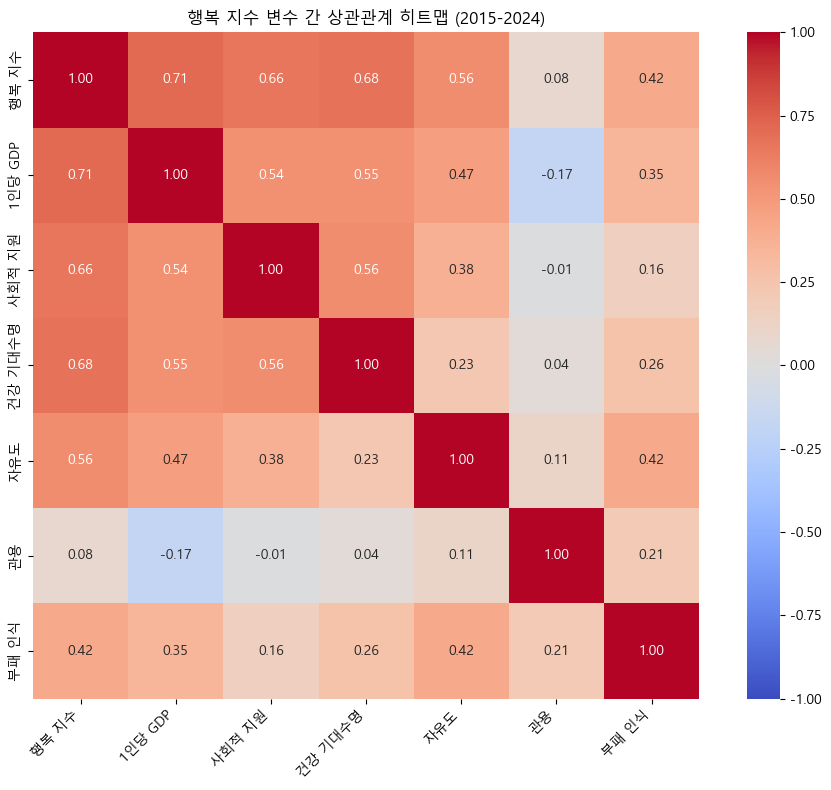

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def generate_correlation_heatmap(processed_df):
    """
    행복 지수 데이터의 주요 수치형 변수 간의 상관관계를 계산하고,
    결과를 히트맵(Heatmap) 형태의 이미지 파일로 저장합니다.

    Parameters:
        processed_df (pandas.DataFrame): 결측치 처리가 완료된 행복 지수 데이터프레임

    Returns:
        None: 별도의 반환값 없이 'correlation_heatmap_kr.png' 파일을 로컬에 저장합니다.
    """
    corr_columns = [
        "happiness_score", "gdp_per_capita", "social_support",
        "healthy_life_expectancy", "freedom", "generosity", "corruption_perception"
    ]   # 상관관계 분석에 사용할 7개의 주요 수치형 변수 목록을 지정합니다.

    kor_mapping = {
        "happiness_score": "행복 지수",
        "gdp_per_capita": "1인당 GDP",
        "social_support": "사회적 지원",
        "healthy_life_expectancy": "건강 기대수명",
        "freedom": "자유도",
        "generosity": "관용",
        "corruption_perception": "부패 인식"
    }

    correlation_matrix = processed_df[corr_columns].corr()  # 지정한 변수들 간의 피어슨 상관계수(Pearson Correlation Coefficient)를 계산하여 행렬(Matrix) 형태로 반환합니다.
    correlation_matrix = correlation_matrix.rename(columns=kor_mapping, index=kor_mapping)

    fig, ax = plt.subplots(figsize=(10, 8)) # 가로 10, 세로 8 인치 크기의 그래프 밑바탕(Figure)을 생성합니다.

    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        vmin=-1,
        vmax=1,
        square=True,
        ax=ax
    )   # Seaborn 라이브러리를 사용하여 상관계수 행렬을 색상으로 표현하는 히트맵을 그립니다.

    plt.xticks(rotation=45, ha='right')
    plt.title("행복 지수 변수 간 상관관계 히트맵 (2015-2024)")
    plt.tight_layout()
    plt.savefig("correlation_heatmap_kr.png")

generate_correlation_heatmap(processed_happiness_df)

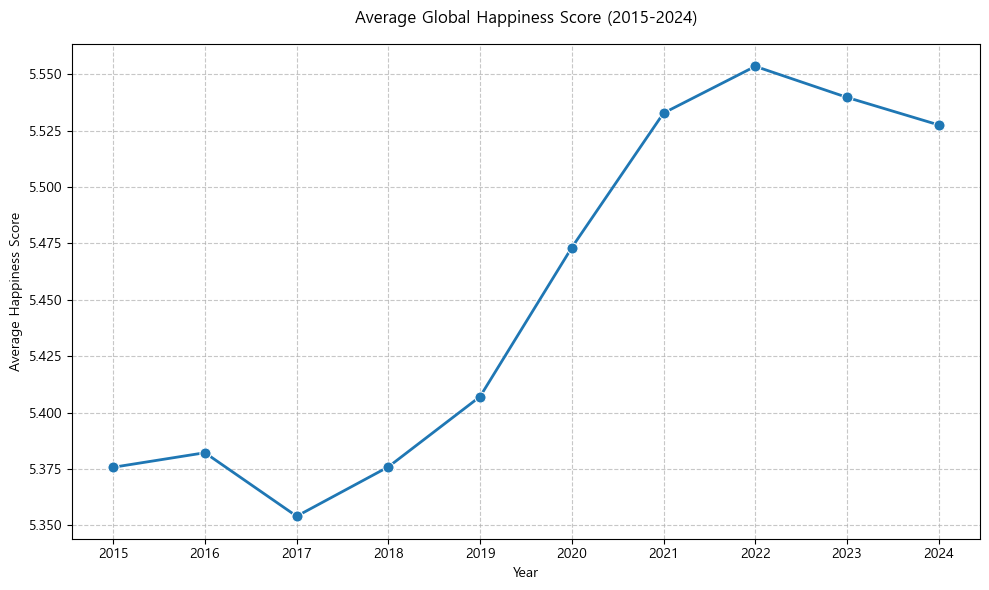

In [7]:
def plot_yearly_happiness_trend(processed_df):
    """
    연도별 전 세계 평균 행복 지수 추이를 계산하여 선 그래프(Line plot)로 시각화하고 저장합니다.

    Parameters:
        processed_df (pandas.DataFrame): 결측치 처리가 완료된 행복 지수 통합 데이터프레임

    Returns:
        None: 별도의 반환값 없이 'yearly_happiness_trend.png' 이미지를 로컬에 저장합니다.
    """
    yearly_avg_df = processed_df.groupby("year")["happiness_score"].mean().reset_index()

    fig, ax = plt.subplots(figsize=(10, 6))

    sns.lineplot(
        data=yearly_avg_df,
        x="year",
        y="happiness_score",
        marker="o",
        ax=ax,
        linewidth=2,
        markersize=8
    )

    ax.set_title("Average Global Happiness Score (2015-2024)", pad=15)
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Happiness Score")
    ax.set_xticks(range(2015, 2025))
    ax.grid(True, linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.savefig("yearly_happiness_trend.png")

plot_yearly_happiness_trend(processed_happiness_df)

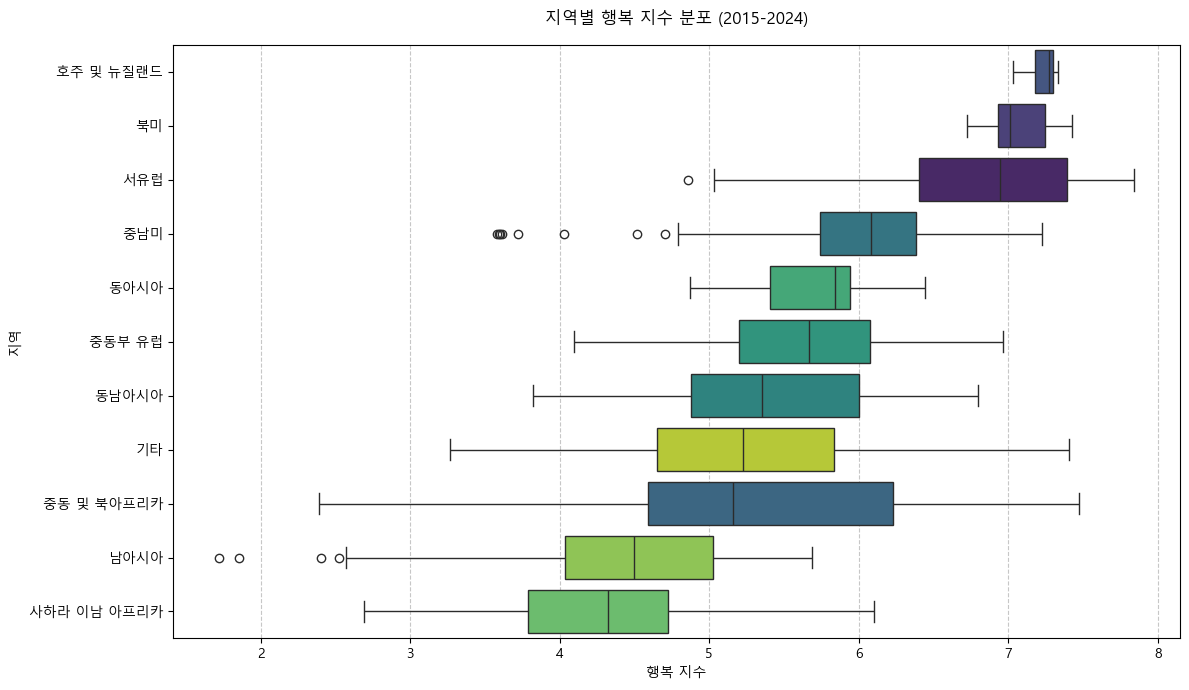

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def analyze_regional_happiness_distribution(data_dir="../data"):
    """
    연도별 행복 지수 데이터를 로드하여 국가별 지역 매핑 및 한글화를 수행한 뒤,
    지역별 행복 지수 분포를 박스플롯(Boxplot)으로 시각화하고 결과를 저장합니다.

    Parameters:
        data_dir (str): CSV 파일들이 저장된 디렉토리 경로 (예: "../data")

    Returns:
        None: 'regional_happiness_distribution_kr.png' 시각화 이미지와
              'regional_average_happiness_kr.csv' 요약 데이터 파일을 로컬에 저장합니다.
    """
    column_mapping = {
        "Country": "country", "Country or region": "country", "Country name": "country",
        "Region": "region", "Regional indicator": "region",
        "Happiness Score": "happiness_score", "Happiness.Score": "happiness_score",
        "Score": "happiness_score", "Happiness score": "happiness_score"
    }

    region_translation = {
        "Australia and New Zealand": "호주 및 뉴질랜드",
        "North America": "북미",
        "Western Europe": "서유럽",
        "Latin America and Caribbean": "중남미",
        "Eastern Asia": "동아시아",
        "Central and Eastern Europe": "중동부 유럽",
        "Southeastern Asia": "동남아시아",
        "Middle East and Northern Africa": "중동 및 북아프리카",
        "Southern Asia": "남아시아",
        "South Asia": "남아시아",
        "Sub-Saharan Africa": "사하라 이남 아프리카",
        "Commonwealth of Independent States": "독립국가연합(CIS)",
        "Other": "기타"
    }

    # 연도별 원본 데이터에서 국가와 지역 매핑 정보를 추출하여 누적할 딕셔너리
    country_to_region = {}

    # 필터링된 개별 연도 데이터프레임을 담을 리스트
    standardized_dfs = []

    for year in range(2015, 2025):
        file_path = os.path.join(data_dir, f"{year}.csv")
        try:
            yearly_df = pd.read_csv(file_path)
            yearly_df = yearly_df.rename(columns=column_mapping)

            # 연도마다 지역 정보가 누락된 경우를 대비해 일관된 국가-지역 맵 생성
            if "region" in yearly_df.columns:
                for _, row in yearly_df.dropna(subset=["country", "region"]).iterrows():
                    if row["country"] not in country_to_region:
                        country_to_region[row["country"]] = row["region"]

            # 메모리 효율성을 위해 필요한 핵심 컬럼만 추출
            avail_cols = [c for c in ["country", "happiness_score"] if c in yearly_df.columns]
            filtered_df = yearly_df[avail_cols].copy()
            filtered_df["year"] = year
            standardized_dfs.append(filtered_df)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    # 리스트에 담긴 데이터프레임을 한 번에 병합
    merged_df = pd.concat(standardized_dfs, ignore_index=True)

    # 구축해 둔 딕셔너리를 사용하여 빈틈없이 지역 정보를 채워 넣음
    merged_df["region"] = merged_df["country"].map(country_to_region)
    merged_df["region"] = merged_df["region"].fillna("Other")

    # 영문 지역명을 준비된 한글 딕셔너리를 통해 변환 (사전에 없으면 원래 값 유지)
    merged_df["region_kr"] = merged_df["region"].map(lambda x: region_translation.get(x, x))

    # 지역별 평균 행복 지수를 계산하고 내림차순으로 정렬 (박스플롯 정렬용)
    region_avg_df = merged_df.groupby("region_kr")["happiness_score"].mean().reset_index()
    region_avg_df = region_avg_df.sort_values(by="happiness_score", ascending=False)

    fig, ax = plt.subplots(figsize=(12, 7))

    # 한글화된 지역명으로 박스플롯 시각화 (평균 행복 지수 순으로 정렬)
    sns.boxplot(
        data=merged_df,
        x="happiness_score",
        y="region_kr",
        hue="region_kr",
        order=region_avg_df["region_kr"],
        ax=ax,
        palette="viridis",
        legend=False
    )

    ax.set_title("지역별 행복 지수 분포 (2015-2024)", pad=15)
    ax.set_xlabel("행복 지수")
    ax.set_ylabel("지역")
    ax.grid(True, linestyle="--", alpha=0.7, axis="x")

    plt.tight_layout()
    plt.savefig("regional_happiness_distribution_kr.png")

    # 요약된 지역별 통계 데이터를 CSV 파일로 추출
    region_avg_df.to_csv("regional_average_happiness_kr.csv", index=False)

analyze_regional_happiness_distribution("../data")

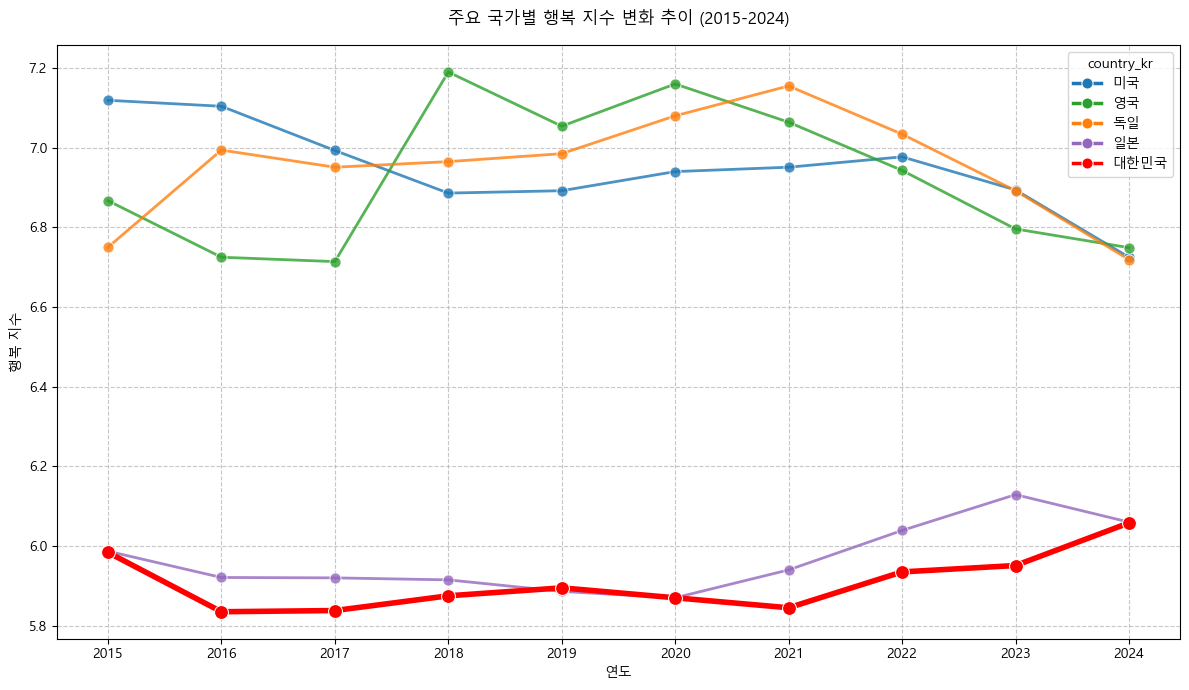

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.rcParams["axes.unicode_minus"] = False

column_mapping = {
    "Country": "country", "Country or region": "country", "Country name": "country",
    "Happiness Score": "happiness_score", "Happiness.Score": "happiness_score",
    "Score": "happiness_score", "Happiness score": "happiness_score"
} # 연도별로 다르게 표기된 컬럼명 통일

country_translation = {
    "South Korea": "대한민국",
    "Japan": "일본",
    "United States": "미국",
    "United Kingdom": "영국",
    "Germany": "독일"
} # 차트 범례 한국어로 변경

target_countries = list(country_translation.keys())
standardized_dfs = []
data_dir = "../data"

for year in range(2015, 2025):
    file_path = os.path.join(data_dir, f"{year}.csv")
    try:
        yearly_df = pd.read_csv(file_path)
        yearly_df = yearly_df.rename(columns=column_mapping)

        avail_cols = [c for c in ["country", "happiness_score"] if c in yearly_df.columns]
        filtered_df = yearly_df[avail_cols].copy()
        filtered_df["year"] = year
        standardized_dfs.append(filtered_df)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
# 15~ 24년 반복문

# year 컬럼을 추가하면서 10년치 개별 데이터 프레임을 하나의 큰 데이터 프레임으로 병함
merged_df = pd.concat(standardized_dfs, ignore_index=True)

major_countries_df = merged_df[merged_df["country"].isin(target_countries)].copy()  # 특정 국가(한,일,미,영,독) 데이터 추출)
major_countries_df["country_kr"] = major_countries_df["country"].map(country_translation)   # 한글 국가명 컬럼 추가


custom_palette = {
    "대한민국": "#FF0000",
    "일본": "#9467bd",
    "미국": "#1f77b4",
    "영국": "#2ca02c",
    "독일": "#ff7f0e"
} # 색상지정

fig, ax = plt.subplots(figsize=(12, 7))

sns.lineplot(
    data=major_countries_df,
    x="year",
    y="happiness_score",
    hue="country_kr",
    palette=custom_palette,
    marker="o",
    linewidth=2.5,
    markersize=8,
    ax=ax
)   # 시각화

for line in ax.lines:
    if line.get_color() == "#FF0000":
        line.set_linewidth(4.0)
        line.set_markersize(10)
        line.set_zorder(5)
    else:
        line.set_linewidth(2.0)
        line.set_alpha(0.8)
# 라인 강조 로직 한국만 두껍게

ax.set_title("주요 국가별 행복 지수 변화 추이 (2015-2024)", pad=15)
ax.set_xlabel("연도")
ax.set_ylabel("행복 지수")
ax.set_xticks(range(2015, 2025))
ax.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("korea_highlighted_happiness_v2_kr.png")

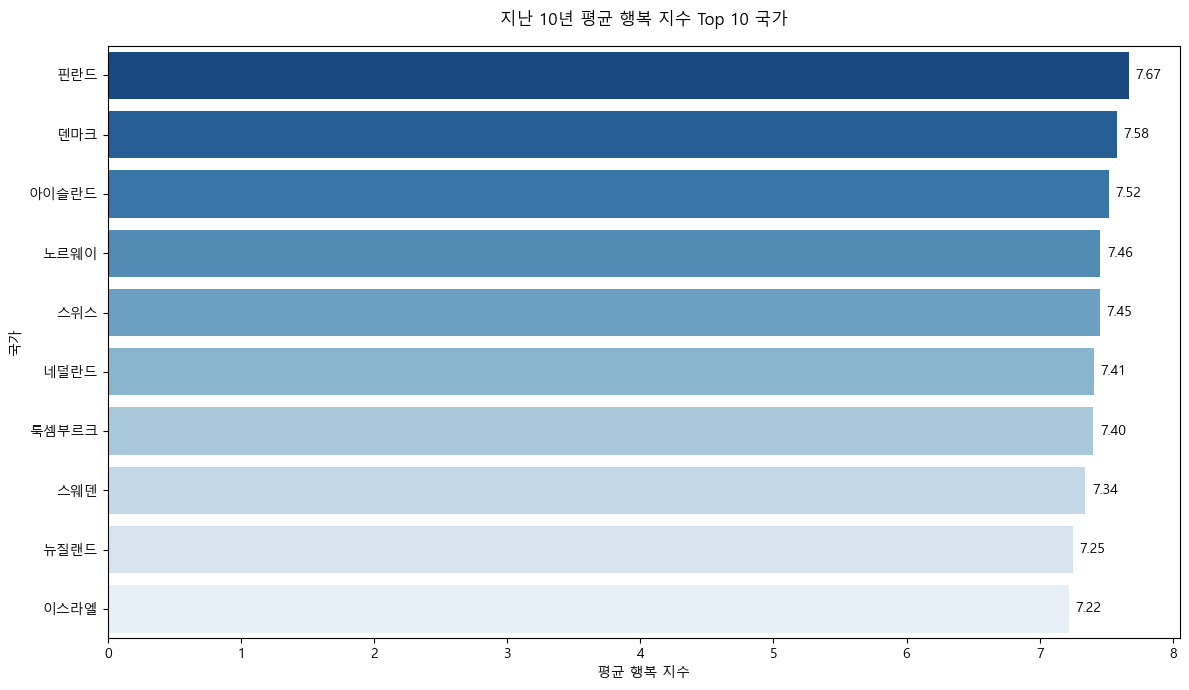

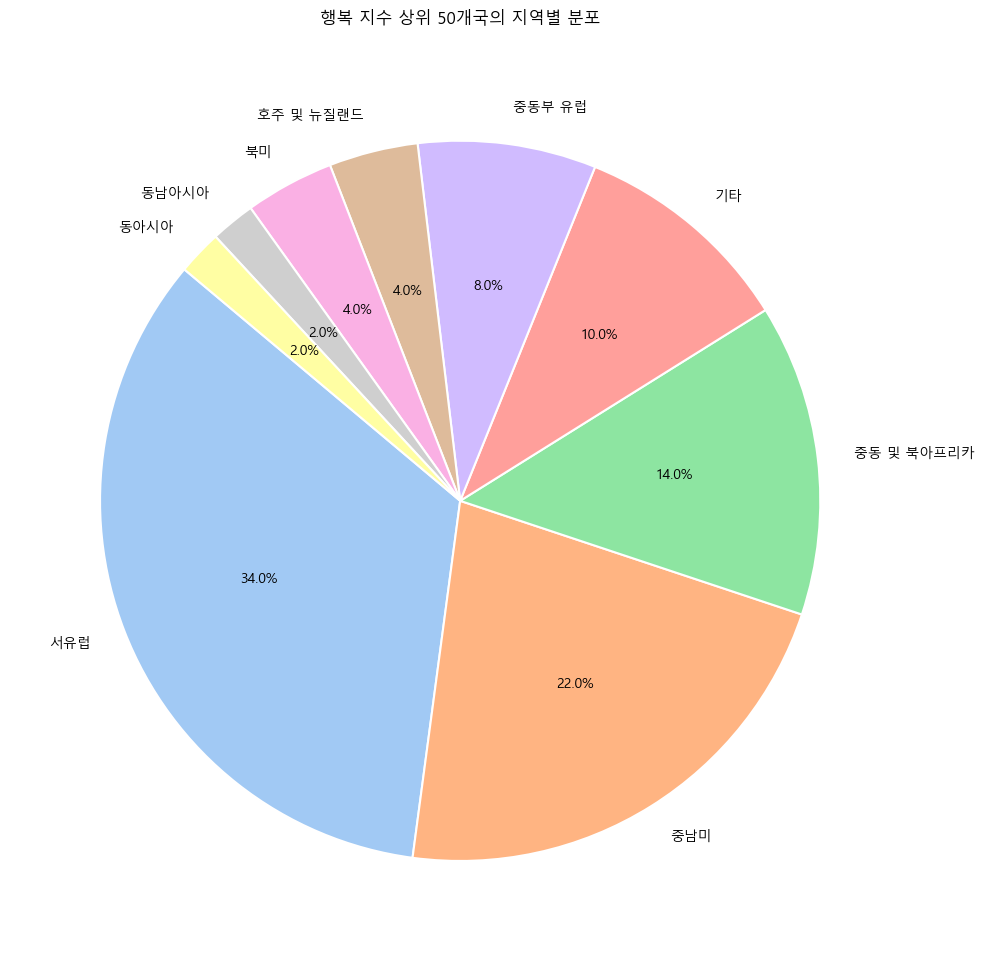

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.rcParams["axes.unicode_minus"] = False

column_mapping = {
    "Country": "country", "Country or region": "country", "Country name": "country",
    "Region": "region", "Regional indicator": "region",
    "Happiness Score": "happiness_score", "Happiness.Score": "happiness_score",
    "Score": "happiness_score", "Happiness score": "happiness_score"
}   # 컬럼명 통일

region_translation = {
    "Australia and New Zealand": "호주 및 뉴질랜드",
    "North America": "북미",
    "Western Europe": "서유럽",
    "Latin America and Caribbean": "중남미",
    "Eastern Asia": "동아시아",
    "Central and Eastern Europe": "중동부 유럽",
    "Southeastern Asia": "동남아시아",
    "Middle East and Northern Africa": "중동 및 북아프리카",
    "Southern Asia": "남아시아",
    "South Asia": "남아시아",
    "Sub-Saharan Africa": "사하라 이남 아프리카",
    "Commonwealth of Independent States": "독립국가연합(CIS)",
    "Other": "기타"
}   # 영문명 한글로 변경

country_translation = {
    "Finland": "핀란드",
    "Denmark": "덴마크",
    "Iceland": "아이슬란드",
    "Norway": "노르웨이",
    "Switzerland": "스위스",
    "Netherlands": "네덜란드",
    "Luxembourg": "룩셈부르크",
    "Luxembourg*": "룩셈부르크",
    "Sweden": "스웨덴",
    "New Zealand": "뉴질랜드",
    "Israel": "이스라엘",
    "Austria": "오스트리아",
    "Canada": "캐나다",
    "Australia": "호주"
}   # 영문명 한그롤 변경

country_to_region = {}
standardized_dfs = []
data_dir = "../data"

for year in range(2015, 2025):
    file_path = os.path.join(data_dir, f"{year}.csv")
    try:
        yearly_df = pd.read_csv(file_path)
        yearly_df = yearly_df.rename(columns=column_mapping)

        if "region" in yearly_df.columns:
            for _, row in yearly_df.dropna(subset=["country", "region"]).iterrows():
                if row["country"] not in country_to_region:
                    country_to_region[row["country"]] = row["region"]

        avail_cols = [c for c in ["country", "happiness_score"] if c in yearly_df.columns]
        filtered_df = yearly_df[avail_cols].copy()
        filtered_df["year"] = year
        standardized_dfs.append(filtered_df)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

merged_df = pd.concat(standardized_dfs, ignore_index=True)
merged_df["region"] = merged_df["country"].map(country_to_region).fillna("Other")
# 전체 데이터에 지역정보를 넣기 > 매핑 안된 국가는 other로 대채
merged_df["region_kr"] = merged_df["region"].map(lambda x: region_translation.get(x, x))
merged_df["country_kr"] = merged_df["country"].map(lambda x: country_translation.get(x, x))

country_avg_df = merged_df.groupby(["country_kr", "region_kr"])["happiness_score"].mean().reset_index()
# 10년치 국가별 평균 행복 지수 계산한뒤 내림차순 정렬
country_avg_df = country_avg_df.sort_values(by="happiness_score", ascending=False)

top_10_df = country_avg_df.head(10)

fig1, ax1 = plt.subplots(figsize=(12, 7))

sns.barplot(
    data=top_10_df,
    x="happiness_score",
    y="country_kr",
    hue="country_kr",
    palette="Blues_r",
    legend=False,
    ax=ax1
)
# 가막대형으로 제작
for i, v in enumerate(top_10_df["happiness_score"]):
    ax1.text(v + 0.05, i, f"{v:.2f}", color="black", va="center")

ax1.set_title("지난 10년 평균 행복 지수 Top 10 국가", pad=15)
ax1.set_xlabel("평균 행복 지수")
ax1.set_ylabel("국가")
plt.tight_layout()
plt.savefig("top_10_happiness_bar_kr_v2.png")


# 상위 50위권 국가 카운트 및 데이터 프레임 제작
top_50_df = country_avg_df.head(50)
region_count_df = top_50_df["region_kr"].value_counts().reset_index()
region_count_df.columns = ["region_kr", "count"]

fig2, ax2 = plt.subplots(figsize=(10, 10))
colors = sns.color_palette("pastel")[0:len(region_count_df)]
# 파이차트 시각화
ax2.pie(
    region_count_df["count"],
    labels=region_count_df["region_kr"],
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    wedgeprops={"edgecolor": "white", "linewidth": 1.5}
)

ax2.set_title("행복 지수 상위 50개국의 지역별 분포", pad=20)
plt.tight_layout()
plt.savefig("top_50_region_pie_kr_v2.png")